In [287]:
from random import choices

import networkx as nx
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


In [9]:

file = open('weic-graphdata/hep.txt', 'r')
first_line = file.readline()
meta = first_line.split()
num_nodes = int(meta[0])
num_edges = int(meta[1])
print(f"|V|: {num_nodes}, |E|: {num_edges}")


edges = [line.strip().split() for line in file.readlines()]
edges = [(int(e[0]), int(e[1])) for e in edges]
len(edges)

|V|: 15233, |E|: 58891


58891

In [150]:
graph = nx.DiGraph()
graph.add_edges_from(edges)
graph.number_of_nodes(), graph.number_of_edges() # 32K edges match the paper
# duplicated edges

(15233, 32235)

In [268]:
def construct_observable(graph, target_visibility, initial_seeds = 4):
    nodes = list(graph.nodes)
    target_num_O = int(target_visibility * num_nodes)
    fully_observ_O = list(np.random.choice(nodes, 
                                           size = initial_seeds, 
                                           replace = False)) # list of fully observable nodes
    all_neighbors = set()
    while len(fully_observ_O) < target_num_O:
        if all_neighbors.issubset(fully_observ_O):
            # when no such neighbors exist, add a random node to O
            non_neighbors = list(set(nodes) - all_neighbors)
            random_node = np.random.choice(non_neighbors, size = 1)[0]
            fully_observ_O.append(random_node)
            all_neighbors.update(set(graph.neighbors(random_node)))
        else: # pick a node from O and add one of its neighbors that is currently not in O to O
            proposed_node_in_O = np.random.choice(fully_observ_O, size = 1)[0]
            neighbors = list(graph.neighbors(proposed_node_in_O))
            while len(neighbors) == 0:
                proposed_node_in_O = np.random.choice(fully_observ_O, size = 1)[0]
                neighbors = list(graph.neighbors(proposed_node_in_O))
            proposed_neighbor = np.random.choice(list(graph.neighbors(proposed_node_in_O)), size = 1)[0]
            if proposed_neighbor not in fully_observ_O:
                fully_observ_O.append(proposed_neighbor)
                all_neighbors.update(list(graph.neighbors(proposed_neighbor)))
    
    # find boundary nodes (neighbors of nodes in O that are not in O)
    boundary_nodes = list(all_neighbors - set(fully_observ_O))
    return fully_observ_O, boundary_nodes

In [269]:
def construct_observable_graph(graph, fully_observ_O, boundary_nodes):
    observable_nodes = fully_observ_O + boundary_nodes
    observable_graph = nx.induced_subgraph(graph, observable_nodes)
    return observable_graph

In [270]:
def seed_weighted_degree(observable_graph, weight = 3, num_seed = 5):
    node_to_outdegree = dict(observable_graph.out_degree())
    
    # add extra weights for boundary nodes
    for node in boundary_nodes:
        node_to_outdegree[node] += weight
    
    # rank nodes from highest out-degree
    node_ranks = sorted(node_to_outdegree.items(), key = lambda x: x[1], reverse = True)
    return [n[0] for n in node_ranks[: num_seed]]

In [271]:
def simulate_weighted_IC(graph, seeds):
    activated = set(seeds)
    inactivated = set(graph.nodes) - activated
    spreading = seeds
    
    node_to_indegree = dict(graph.in_degree())
    while len(inactivated) != 0:
        spreading_next = []
        for node in spreading:
            neighbors = list(set(graph.neighbors(node)) - set(activated))
            probs = [1.0 / deg for deg in dict(graph.in_degree(neighbors)).values()]
            to_activate = np.random.binomial(([1] * len(neighbors)), probs)
            infected = [node for node, infected in zip(neighbors, to_activate) if infected == 1]
            activated.update(infected)
            inactivated -= set(infected)
            spreading_next = spreading_next + infected
        spreading = spreading_next
        if len(spreading) == 0:
            break
    
    return activated

In [272]:
nodes = list(graph.nodes)

target_visibility = 0.2
fully_observ_O, boundary_nodes = construct_observable(graph, target_visibility)
observable_graph = construct_observable_graph(graph, fully_observ_O, boundary_nodes)
seeds = seed_weighted_degree(observable_graph, weight = 3, num_seed = 5)
activated_nodes = simulate_weighted_IC(graph, seeds)
print(f"spread: {len(activated_nodes)}")

spread: 123


In [273]:
def add_and_remove_edges(graph, num_replace):    
    '''    
    remove a connection and add a new connection to random other node
    for `num_replace` edges
   
    '''      
    edges = list(graph.edges())
    to_delete_edges = choices(edges, k = num_replace)
    new_graph = nx.DiGraph(graph)
    new_graph.remove_edges_from(to_delete_edges)
    
    # find new connections
    for e in to_delete_edges:
        num_nodes = new_graph.number_of_nodes()
        new_neighbor = np.random.randint(0, num_nodes - 1)
        while new_neighbor == e[1]:
            new_neighbor = np.random.randint(0, num_nodes - 1)
        new_graph.add_edge(e[0], new_neighbor)
        
    return new_graph

In [274]:
new_graphs = []
deg_assortativity = []
for p in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    new_graph = add_and_remove_edges(graph, num_replace = int(p * graph.number_of_edges()))
    new_graphs.append(new_graph)
    deg_assortativity.append(nx.degree_assortativity_coefficient(new_graph, x = 'out', y = 'out'))
print(deg_assortativity)

[0.3148708146541458, 0.3051402169836398, 0.290703648402119, 0.27355001189740175, 0.2397793721419453, 0.21704663087483905, 0.18972438134732433, 0.16794126508781984, 0.14911596407600908, 0.13430689849030536, 0.11989591646657462, 0.10787439028403602]


In [293]:
results_spreads = []
results_deg_assorts = []
results_visibility = []
for i, g in enumerate(new_graphs):
    nodes = list(g.nodes)
    print(f"Running for graph with deg assort {deg_assortativity[i]}")
    for target_visibility in [k * 0.01 for k in range(1, 22, 2)]:
        spreads = []
        for t in range(5):
            fully_observ_O, boundary_nodes = construct_observable(g, target_visibility)
            observable_graph = construct_observable_graph(g, fully_observ_O, boundary_nodes)
            seeds = seed_weighted_degree(observable_graph, weight = 3, num_seed = 5)
            activated_nodes = simulate_weighted_IC(g, seeds)
            spreads.append(len(activated_nodes))
        avg_spread = np.mean(spreads)
        print(f"\tvisibility: {target_visibility}, avg spread: {avg_spread}")
        results_spreads.append(avg_spread)
        results_deg_assorts.append(deg_assortativity[i])
        results_visibility.append(target_visibility)

Running for graph with deg assort 0.3148708146541458
	visibility: 0.01, avg spread: 64.6
	visibility: 0.03, avg spread: 78.0
	visibility: 0.05, avg spread: 121.2
	visibility: 0.07, avg spread: 114.8
	visibility: 0.09, avg spread: 121.4
	visibility: 0.11, avg spread: 125.8
	visibility: 0.13, avg spread: 108.2
	visibility: 0.15, avg spread: 119.4
	visibility: 0.17, avg spread: 100.8
	visibility: 0.19, avg spread: 119.2
	visibility: 0.21, avg spread: 104.0
Running for graph with deg assort 0.3051402169836398
	visibility: 0.01, avg spread: 65.2
	visibility: 0.03, avg spread: 117.2
	visibility: 0.05, avg spread: 87.0
	visibility: 0.07, avg spread: 142.2
	visibility: 0.09, avg spread: 87.4
	visibility: 0.11, avg spread: 143.6
	visibility: 0.13, avg spread: 152.2
	visibility: 0.15, avg spread: 136.8
	visibility: 0.17, avg spread: 147.6
	visibility: 0.19, avg spread: 165.4
	visibility: 0.21, avg spread: 185.0
Running for graph with deg assort 0.290703648402119
	visibility: 0.01, avg spread: 59

In [294]:
# run on original graph
results_spreads_original = [] 
results_deg_assorts_original = []
results_visibility_original = []

nodes = list(graph.nodes)
deg_assort = nx.degree_assortativity_coefficient(graph, x = 'out', y = 'out')
print(f"Running for the original graph with deg assort {deg_assort}")
for target_visibility in [k * 0.01 for k in range(1, 22, 2)]:
    spreads = []
    for t in range(5):
        fully_observ_O, boundary_nodes = construct_observable(graph, target_visibility)
        observable_graph = construct_observable_graph(graph, fully_observ_O, boundary_nodes)
        seeds = seed_weighted_degree(observable_graph, weight = 3, num_seed = 5)
        activated_nodes = simulate_weighted_IC(graph, seeds)
        spreads.append(len(activated_nodes))
    avg_spread = np.mean(spreads)
    print(f"\tvisibility: {target_visibility}, avg spread: {avg_spread}")
    results_spreads_original.append(avg_spread)
    results_deg_assorts_original.append(deg_assort)
    results_visibility_original.append(target_visibility)

Running for the original graph with deg assort 0.3161257813793155
	visibility: 0.01, avg spread: 38.2
	visibility: 0.03, avg spread: 67.6
	visibility: 0.05, avg spread: 108.4
	visibility: 0.07, avg spread: 100.8
	visibility: 0.09, avg spread: 108.4
	visibility: 0.11, avg spread: 110.0
	visibility: 0.13, avg spread: 90.4
	visibility: 0.15, avg spread: 109.6
	visibility: 0.17, avg spread: 110.8
	visibility: 0.19, avg spread: 108.6
	visibility: 0.21, avg spread: 127.0


In [310]:
results = pd.DataFrame.from_dict({
        "avg_spread" : results_spreads,
        "deg_assortativity": results_deg_assorts,
        "visibility": results_visibility,
    })
results_original = pd.DataFrame.from_dict({
        "avg_spread" : results_spreads_original,
        "deg_assortativity": results_deg_assorts_original,
        "visibility": results_visibility_original,
    })
results['deg_assortativity_str'] = results["deg_assortativity"].round(2).astype(str)
results_original['deg_assortativity_str'] = results_original["deg_assortativity"].round(2).astype(str) + " (original)"

result_df = pd.concat([results_original, results])
result_df["visibility"] = result_df["visibility"]  * 100

result_df.to_csv("results.csv", index = False)

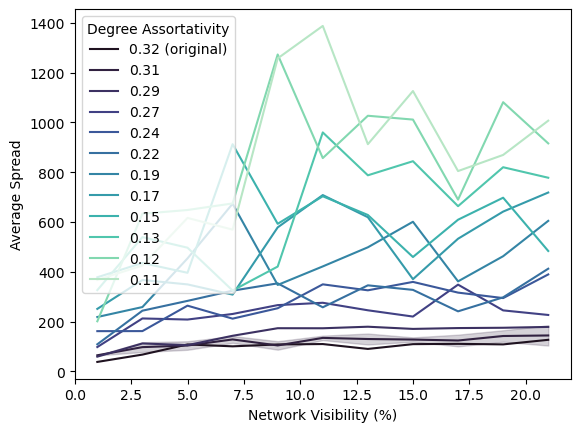

In [314]:
sns.lineplot(data = result_df, x = "visibility",
             y = "avg_spread", hue = "deg_assortativity_str",
            palette = "mako")
plt.ylabel("Average Spread")
plt.xlabel("Network Visibility (%)")
plt.legend(title = "Degree Assortativity")
plt.savefig("result.png", dpi = 300)

In [315]:
for i, g in enumerate(new_graphs):
    nx.write_edgelist(g, f"new_graph_{i}.edgelist")